# Diabetes prediction: gradient boosting

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import configuration as config
import functions as funcs

## 1. Data preparation

### 1.1. Load data from disk

In [2]:
with open(config.DATA_FILE, 'rb') as input_file:
    dataset=pickle.load(input_file)

training_df=dataset['training']
testing_df=dataset['testing']

### 1.2. Inspect

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
10,0.346287,-0.301950,1.669300,0.205563,0.117037,0.783872,-1.090868,0.032714,0
529,-1.584069,-0.265127,-0.600537,-0.920110,0.183907,-1.235844,0.907265,0.143181,0
131,1.340850,0.122066,-1.356016,0.349894,-0.094144,0.200501,1.653842,0.342824,1
187,-0.812301,0.320701,2.174286,1.183462,-1.281213,0.010094,1.848371,0.342824,1
409,-0.812301,1.571838,-0.348570,1.855405,2.467712,1.364800,1.004892,-0.213442,1


## 3. Baseline model

In [4]:
model=GradientBoostingClassifier()
model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy=accuracy_score(model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Accuracy of gradient boosting model: {accuracy:.1f}%')

Accuracy of gradient boosting model: 92.9%


In [5]:
cross_val_scores={
    'Model': [],
    'Score': []
}

scores=cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Baseline']*len(scores))
cross_val_scores['Score'].extend(scores)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 75.9 +/- 5.6%


## 4. Hyperparameter optimization

### 4.1. Hyperparameter grid search

In [6]:
%%time

hyperparameters={
    'n_estimators':[10,20,30],
    'criterion':['friedman_mse', 'squared_error'],
    'max_depth':[4,8,16],
    'min_samples_split':[2,4,8],
    'min_samples_leaf':[1,2,4],
    'min_weight_fraction_leaf':[0.001,0.01,0.1],
    'max_features':[0.25,0.5,0.75],
    'min_impurity_decrease':[0,0.0001,0.001],
    'ccp_alpha':[0.0,0.0001,0.001,0.01],
}

search=GridSearchCV(
    model,
    hyperparameters,
    return_train_score=True,
    cv=7,
    n_jobs=-1
)

search_results=search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
model=search_results.best_estimator_
hyperparameters=search_results.best_params_

print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()


Best hyperparameters:

 ccp_alpha: 0.001
 criterion: friedman_mse
 max_depth: 8
 max_features: 0.75
 min_impurity_decrease: 0.0001
 min_samples_leaf: 4
 min_samples_split: 4
 min_weight_fraction_leaf: 0.001
 n_estimators: 30

CPU times: user 9min 56s, sys: 13.2 s, total: 10min 9s
Wall time: 13min 23s


### 4.2. Hyperparameter optimization results

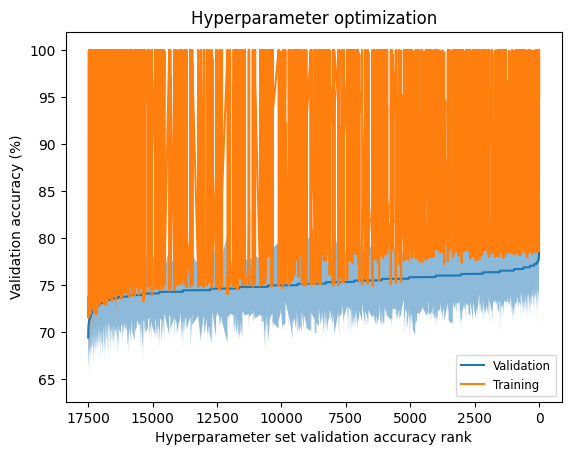

In [7]:
funcs.plot_cross_validation(search_results)

### 4.3. Cross-validation of optimized model

In [8]:
scores=cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Optimized']*len(scores))
cross_val_scores['Score'].extend(scores)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 76.7 +/- 3.7%


## 5. Evaluation

### 5.1. Optimized vs baseline GradientBoostingClassifier

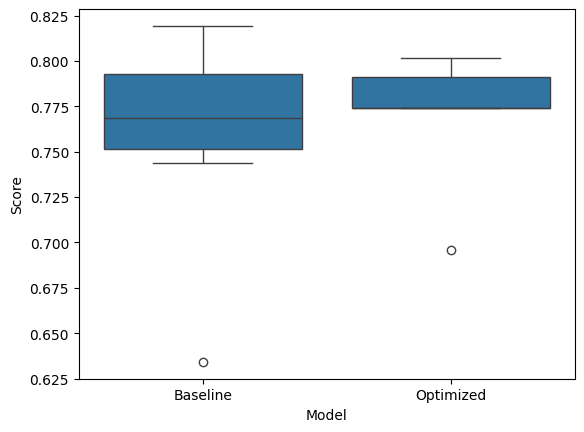

In [9]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.show()

### 5.2. LogisticRegression vs RandomForest vs GradientBoostingClassifier

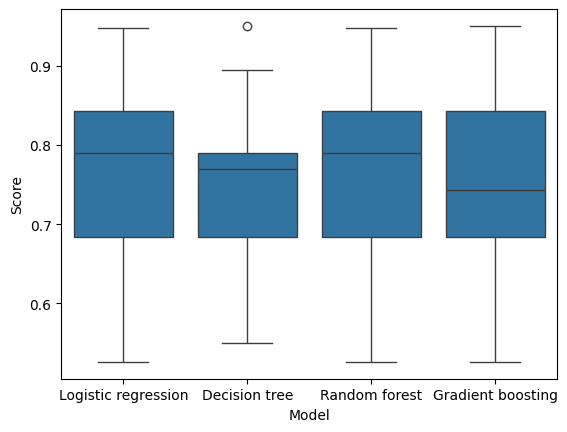

In [10]:
models={}

models['Logistic regression']=LogisticRegression().fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

with open(config.DECISION_TREE_MODEL, 'rb') as input_file:
    models['Decision tree']=pickle.load(input_file)

with open(config.RANDOM_FOREST_MODEL, 'rb') as input_file:
    models['Random forest']=pickle.load(input_file)

models['Gradient boosting']=model

cross_val_scores={
    'Model': [],
    'Score': []
}

for model_name, model in models.items():

    scores=cross_val_score(
        model,
        training_df.drop('Outcome', axis=1),
        training_df['Outcome'],
        cv=30,
        n_jobs=-1
    )

    cross_val_scores['Model'].extend([model_name]*len(scores))
    cross_val_scores['Score'].extend(scores)

sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.show()

### 5.3. Test set performance

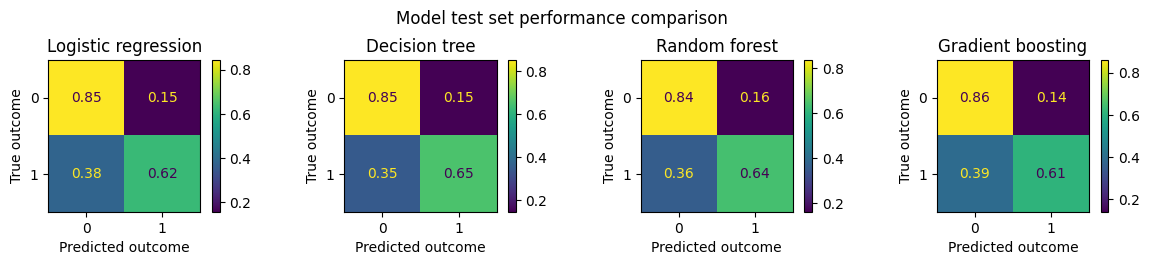

In [11]:
fig, axs = plt.subplots(1,4, figsize=(12,2.5))
axs=axs.flatten()

fig.suptitle(f'Model test set performance comparison')

for i, (model_name, model) in enumerate(models.items()):

    testing_predictions=model.predict(testing_df.drop('Outcome', axis=1))
    accuracy=accuracy_score(testing_predictions, testing_df['Outcome'])*100

    # Plot the confusion matrix
    cm=confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    _=cm_disp.plot(ax=axs[i])

    axs[i].set_title(model_name)
    axs[i].set_xlabel('Predicted outcome')
    axs[i].set_ylabel('True outcome')

fig.tight_layout()

## 6. Save

### 6.1. Optimized hyperparameters

In [12]:
with open(config.GRADIENT_BOOSTING_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(hyperparameters, output_file)

### 6.2. Model

In [13]:
with open(config.GRADIENT_BOOSTING_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)